* Svalbard 17-02, 77-80
* Switzerland 7-10, 45-48
* Abu sari 28-31, 19-22
* Lake Victoria 29-32, -2-1
* Eswatini 29-32, -25--28
* IIle de la possesion 50-53, -45--48
* Concordia station 120-123, -74--77

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from datetime import datetime
import os
from IPython.display import display 

# Importing the dataset



In [7]:
def parse_giovanni_timeseries(filepath):
    """
    Parse a CSV file from NASA Giovanni time series data.
    
    Args:
        filepath (str): Path to the CSV file
    
    Returns:
        tuple: (pandas.DataFrame, dict) containing parsed data and metadata
    """
    # Collect metadata
    metadata = {}
    with open(filepath, 'r') as file:
        for line in file:
            if line.startswith('2004-'):
                break
            if ':' in line:
                key, value = line.split(',', 1)
                metadata[key.strip()] = value.strip().strip('"')
    #fill_value = float(metadata['Fill Value (mean_OMDOAO3e_003_ColumnAmountO3):'])
    fill_value = -1.267651e+30
    # Read data into pandas DataFrame
    df = pd.read_csv(filepath,  
                     header=8,  # Explicitly specify header row
                     na_values=[(fill_value, 'NaN')])
    df.columns = ['date', 'Total_column_Ozon']
    df['Total_column_Ozon'] = df['Total_column_Ozon'].replace(fill_value, np.nan)
    df = df[df['Total_column_Ozon'].notna()]
    df['date'] = pd.to_datetime(df['date']) 
    
    return df, metadata

def calculate_monthly_averages(df):
    """
    Calculate monthly averages from a DataFrame with a datetime column
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame with a datetime column
    
    Returns:
    pandas.DataFrame: DataFrame with monthly averaged data
    """
    # Convert the time column to datetime if it's not already
    df['date'] = pd.to_datetime(df['date'])  # Assumes 'date' is the column name
    
    # Group by year and month, then calculate mean for numeric columns
    monthly_averages = df.groupby(pd.Grouper(key='date', freq='M')).mean()
    
    # Reset index to make date a column again
    monthly_averages.reset_index(inplace=True)
    monthly_averages['date'] = monthly_averages['date'].dt.strftime('%Y-%m')
    
    return monthly_averages

def match_station_files(stations, data_folder):
    """
    Match CSV files for given stations based on specific naming patterns.
    
    Parameters:
    -----------
    stations : list
        List of station names to match (e.g., ['swi', 'ita'])
    data_folder : str
        Path to the folder containing CSV files
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with columns: 'station', 'ozon_file', 'uv_file'
    """
    # Validate input
    if not os.path.isdir(data_folder):
        raise ValueError(f"The specified folder does not exist: {data_folder}")
    
    # Lists to store matched files
    matched_files = []
    
    # Get all CSV files in the folder
    all_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
    
    for station in stations:
        # Find matching files for each station
        ozon_file = next((f for f in all_files 
                          if f.endswith(f'{station}.csv') and 'OMDOAO3e' in f), None)
        
        uv_file = next((f for f in all_files 
                        if f.endswith(f'{station}.csv') and 'OMUVBd' in f), None)
        
        # If either file is not found, print a warning
        if not ozon_file or not uv_file:
            print(f"Warning: Not all files found for station {station}")
        
        # Append to results
        matched_files.append({
            'station': station,
            'ozon_file': ozon_file,
            'uv_file': uv_file
        })
    
    # Convert to DataFrame
    return pd.DataFrame(matched_files)

def calculate_anual_variability(monthly_averages):
    """
    Calculate yearly variability metrics for each column in monthly averaged data
    
    Parameters:
    monthly_averages (pandas.DataFrame): DataFrame with monthly averages 
                                         (date column in 'YYYY-MM' format)
    
    Returns:
    pandas.DataFrame: Dataframe with variability metrics for each column per year
    """
    # Ensure date is a datetime column
    monthly_averages['date'] = pd.to_datetime(monthly_averages['date'])
    
    # Group by year
    yearly_metrics = monthly_averages.groupby(monthly_averages['date'].dt.month)
    
    # Initialize results dictionary
    variability_results = {}
    
    # Identify numeric columns, excluding the date column
    numeric_columns = monthly_averages.select_dtypes(include=[np.number]).columns
    numeric_columns = [col for col in numeric_columns if col != 'date']
    
    for column in numeric_columns:
        # Calculate yearly variability metrics
        column_variability = {
            'mean': yearly_metrics[column].mean(),
            'std': yearly_metrics[column].std(),
            'coefficient_of_variation': yearly_metrics[column].std() / yearly_metrics[column].mean() * 100,
            'min': yearly_metrics[column].min(),
            'max': yearly_metrics[column].max(),
            'range': yearly_metrics[column].max() - yearly_metrics[column].min()
        }
        
        # Convert to DataFrame
        variability_results[column] = pd.DataFrame(column_variability).T
    
    # Combine results into a single multi-index DataFrame if multiple columns
    if len(variability_results) > 1:
        final_result = pd.concat(variability_results, axis=1)
    else:
        final_result = list(variability_results.values())[0]
    
    return final_result

def calculate_yearly_variability(monthly_averages):
    """
    Calculate yearly variability metrics for each column in monthly averaged data
    
    Parameters:
    monthly_averages (pandas.DataFrame): DataFrame with monthly averages 
                                         (date column in 'YYYY-MM' format)
    
    Returns:
    pandas.DataFrame: Dataframe with variability metrics for each column per year
    """
    # Ensure date is a datetime column
    monthly_averages['date'] = pd.to_datetime(monthly_averages['date'])
    
    # Group by year
    yearly_metrics = monthly_averages.groupby(monthly_averages['date'].dt.year)
    
    # Initialize results dictionary
    variability_results = {}
    
    # Identify numeric columns, excluding the date column
    numeric_columns = monthly_averages.select_dtypes(include=[np.number]).columns
    numeric_columns = [col for col in numeric_columns if col != 'date']
    
    for column in numeric_columns:
        # Calculate yearly variability metrics
        column_variability = {
            'mean': yearly_metrics[column].mean(),
            'std': yearly_metrics[column].std(),
            'coefficient_of_variation': yearly_metrics[column].std() / yearly_metrics[column].mean() * 100,
            'min': yearly_metrics[column].min(),
            'max': yearly_metrics[column].max(),
            'range': yearly_metrics[column].max() - yearly_metrics[column].min()
        }
        
        # Convert to DataFrame
        variability_results[column] = pd.DataFrame(column_variability).T
    
    # Combine results into a single multi-index DataFrame if multiple columns
    if len(variability_results) > 1:
        final_result = pd.concat(variability_results, axis=1)
    else:
        final_result = list(variability_results.values())[0]
    
    return final_result

In [8]:
datadir = 'data/'
imagedir = 'images/'
if not os.path.exists(imagedir):
    os.makedirs(imagedir)
    
uv_index_name = 'g3.areaAvgTimeSeries.OMUVBd_003_UVindex.20041001-20241119'
ozon_name = 'g4.areaAvgTimeSeries.OMDOAO3e_003_ColumnAmountO3.20041001-20241119'
station_names = ['swal', 'swi', 'nil', 'vic', 'swa', 'ile', 'con']
full_station_names = ['Svalbard 78°N', 'Switzerland 46°N', 'Abu Sari 20°N', 'Lake Victoria 0°NS','Eswatini 25°S', 'Ile de la Possession 45°S', 'Concordia station 75°S']
filename_df = match_station_files(station_names, datadir)

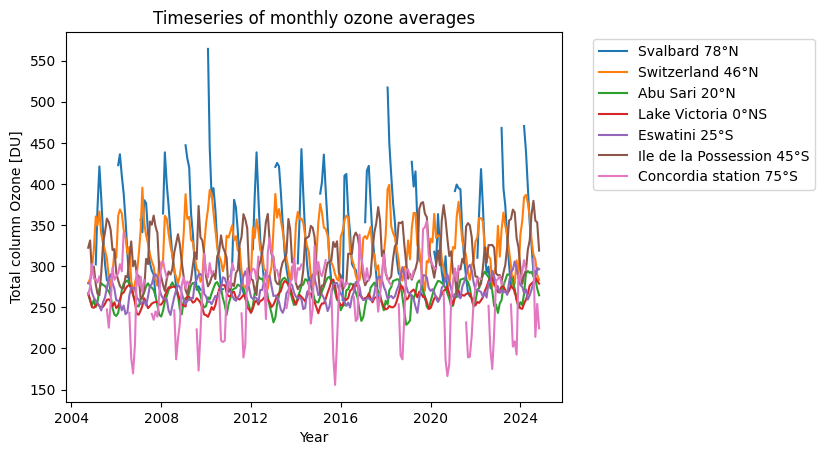

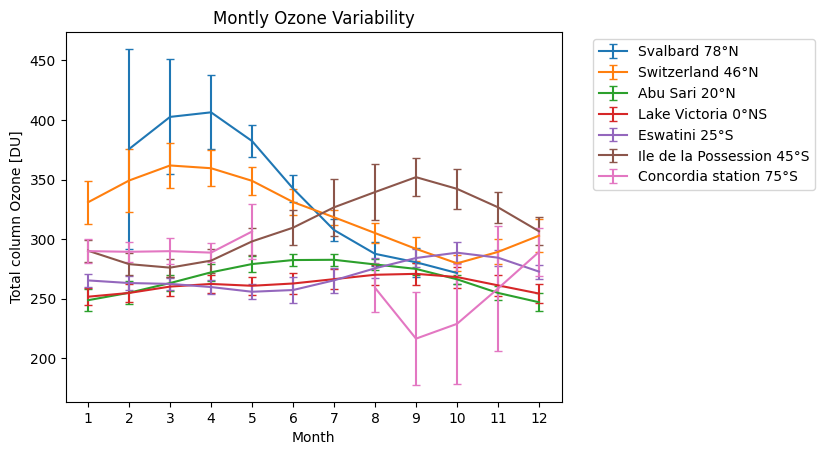

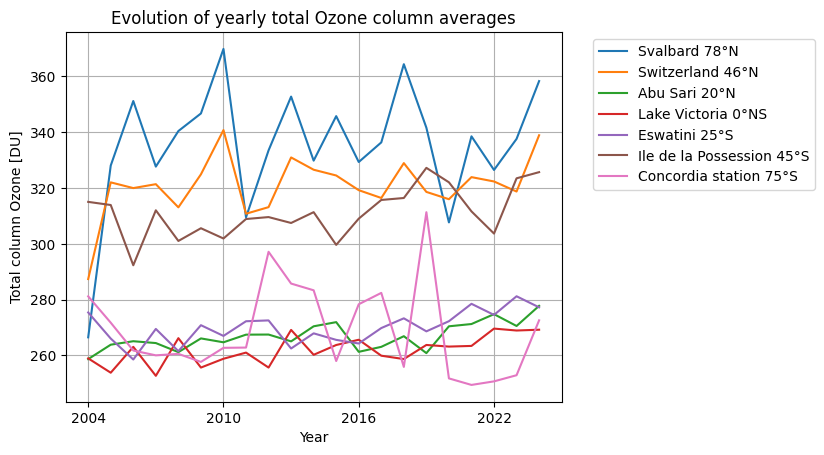

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Code for ozon

plt.figure()
for index, row in filename_df.iterrows():
    df , metadata = parse_giovanni_timeseries('data/'+ row[1])
    df_m = calculate_monthly_averages(df)
    
    plt.plot(pd.to_datetime(df_m['date']), df_m['Total_column_Ozon'], label=full_station_names[index] )
    '''display(df)
    display(df_m)
    display(df_var)'''

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xlabel('Year')
plt.ylabel('Total column Ozone [DU]')
plt.title('Timeseries of monthly ozone averages')
plt.savefig(imagedir + 'monthly_ozone_timeseries.png', bbox_inches='tight')
plt.show()



plt.figure()
for index, row in filename_df.iterrows():
    df , metadata = parse_giovanni_timeseries('data/'+ row[1])
    df_m = calculate_monthly_averages(df)
    df_var = calculate_anual_variability(df_m).T
    #plt.plot(df_var['mean'], label=full_station_names[index] )
    plt.errorbar(np.arange(1,13),df_var['mean'], yerr=df_var['std'] ,fmt='', capsize=3, label=full_station_names[index])

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xticks(np.arange(1,13))
plt.xlabel('Month')
plt.ylabel('Total column Ozone [DU]')
plt.title('Montly Ozone Variability')
plt.savefig(imagedir + 'monthly_ozone_variability.png', bbox_inches='tight')
plt.show()

plt.figure()
for index, row in filename_df.iterrows():
    df , metadata = parse_giovanni_timeseries('data/'+ row[1])
    df_m = calculate_monthly_averages(df)
    df_var = calculate_yearly_variability(df_m).T
    plt.plot(df_var['mean'], label=full_station_names[index] )

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xlabel('Year')
plt.xticks(np.arange(2004,2024,6))
plt.ylabel('Total column Ozone [DU]')
plt.title('Evolution of yearly total Ozone column averages')
plt.grid()
plt.savefig(imagedir + 'yearly_ozone_timeseries.png', bbox_inches='tight')
plt.show()

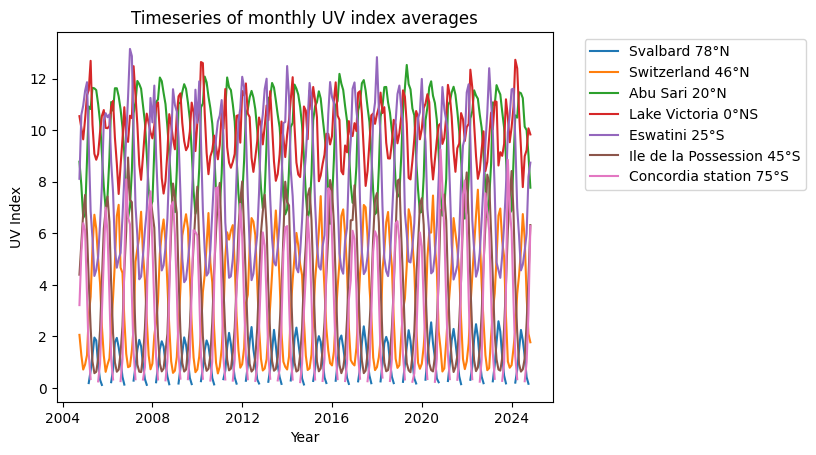

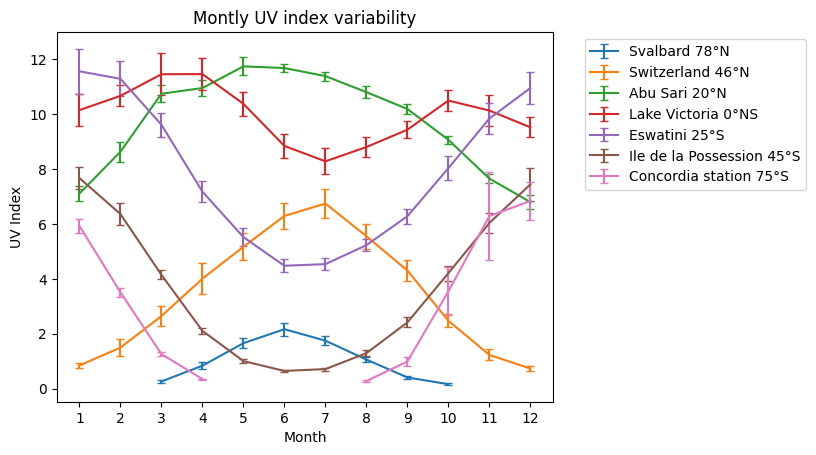

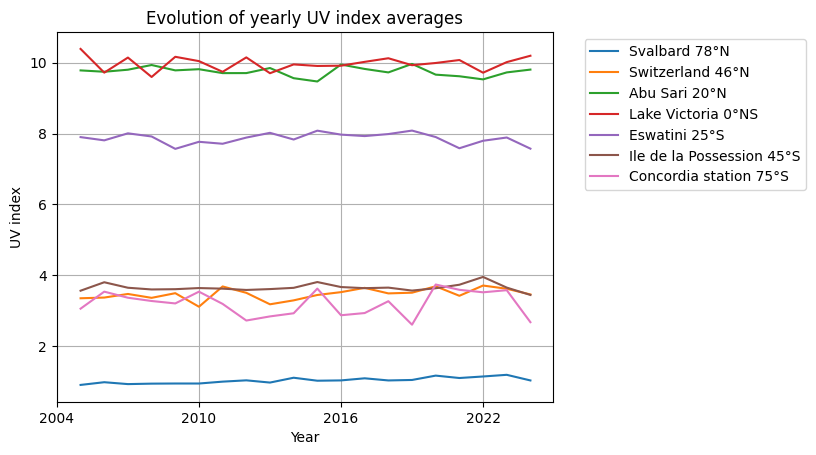

In [12]:
plt.figure()
for index, row in filename_df.iterrows():
    df , metadata = parse_giovanni_timeseries('data/'+ row[2])
    df_m = calculate_monthly_averages(df)
    
    plt.plot(pd.to_datetime(df_m['date']), df_m['Total_column_Ozon'], label=full_station_names[index] )
    '''display(df)
    display(df_m)
    display(df_var)'''

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xlabel('Year')
plt.ylabel('UV Index')
plt.title('Timeseries of monthly UV index averages')
plt.savefig(imagedir + 'monthly_uv_timeseries.png', bbox_inches='tight')
plt.show()


plt.figure()
for index, row in filename_df.iterrows():
    df , metadata = parse_giovanni_timeseries('data/'+ row[2])
    df_m = calculate_monthly_averages(df)
    df_var = calculate_anual_variability(df_m).T
    #plt.plot(df_var['mean'], label=full_station_names[index] )
    plt.errorbar(np.arange(1,13),df_var['mean'], yerr=df_var['std'] ,fmt='', capsize=3, label=full_station_names[index])    

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xticks(np.arange(1,13))
plt.xlabel('Month')
plt.ylabel('UV Index')
plt.title('Montly UV index variability')
plt.savefig(imagedir + 'monthly_uv_variability.png', bbox_inches='tight')
plt.show()

plt.figure()
first = True
for index, row in filename_df.iterrows():
    
    df , metadata = parse_giovanni_timeseries('data/'+ row[2])
    df_m = calculate_monthly_averages(df)
    df_var = calculate_yearly_variability(df_m).T
    df_var = df_var.drop(2004, axis=0)
    plt.plot(df_var['mean'], label=full_station_names[index] )
    #plt.errorbar(np.arange(1,22),df_var['mean'], yerr=df_var['std'] ,fmt='', capsize=3, label=full_station_names[index])    
    '''display(df)
    display(df_m)
    display(df_var)'''

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xlabel('Year')
plt.xticks(np.arange(2004,2024,6))
plt.ylabel('UV index')
plt.title('Evolution of yearly UV index averages')
plt.grid()
plt.savefig(imagedir + 'yearly_uv_timeseries.png', bbox_inches='tight')
plt.show()